# Cloud Optimized ERA5

In their [public dataset program](https://cloud.google.com/storage/docs/public-datasets), Google's Cloud Storage provides a variety of public datasets that can be accessed by the community. Google pays for the hosting of these datasets.

One of these datasets is an "Analysis-Ready, Cloud Optimized" [(ARCO) ERA5 dataset](https://github.com/google-research/arco-era5). This is based on the European Centre for Medium-Range Weather Forecasts (ECMWF) [Atmospheric Reanalysis product](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5), a very commonly used dataset for world-wide historical meteorological parameters ranging from 1940 to now.

### Accessing the dataset

This dataset uses [Zarr](https://zarr.dev/) to make access very easy. 

You might need to install the following dependencies still:

In [ ]:
%pip install xarray matplotlib zarr gcsfs

Now we can open the Zarr store with the following code ([copied from the ARCO-ERA5 github page](https://github.com/google-research/arco-era5)).

In [14]:
import xarray

ds = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)
ar_full_37_1h = ds.sel(time=slice(ds.attrs['valid_time_start'], ds.attrs['valid_time_stop']))

### How to use xarray with Zarr stores

The data is opened as an xarray "Dataset". This dataset holds all variables and their associated dimensions and coordinates.
As you can see, there are 273 variables contained in this dataset:

In [15]:
ar_full_37_1h

<xarray.Dataset> Size: 2PB
Dimensions:                                                          (
                                                                      time: 740712,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 6MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 3TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 3TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 3TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 3TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 3TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 3TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 3TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 3TB ...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-09-27 08:06:09.120900
    valid_time_stop:   2024-06-30

With xarray we can quite quickly make a selection of the data (here a certain point in time), and plot it.

Note that *only once the actual underlying data is needed* for creating output, such as plotting, the data is retrieved from Google's servers:

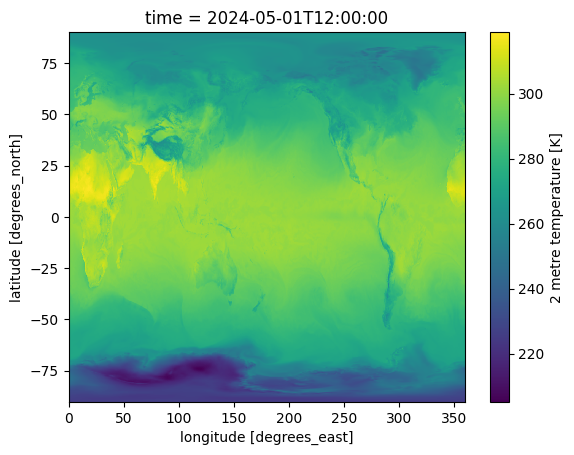

In [16]:
ar_full_37_1h["2m_temperature"].sel(time="2024-05-01T12:00:00").plot()

### Caveats with using the ARCO-ERA5 dataset

One main drawback of the ARCO-ERA5 dataset is how the data is organized.
Data is stored in blocks called "chunks", which is a manageable piece of a larger dataset. They are often used to store information about specific topics or categories.

When retrieving data, the whole chunk has to be retrieved. Partial retrieval of chunks is not possible.

The ARCO-ERA5 dataset is organized like the following illustration:

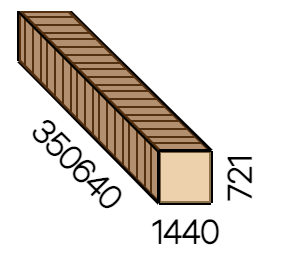

Where the latitude and longitude dimensions (sizes 721 and 1440 respectively) are all in the same chunk, while each time step is on a separate chunk.
When you want to retrieve data for a single lat/lon, for example, a timeseries of air temperature near Leiden, the Netherlands, every single chunk of the entire air temperature array has to be downloaded.

There are tools such as [Rechunker](https://rechunker.readthedocs.io/) which can reorganize the data for you, but this requires storing a copy of the data elsewhere.

#### Demonstration of chunk issue

The code cell below demonstrates the problem. We request the air temperature data for the data point closest to leiden, but only one out of every 720 timesteps (approximately a month), for the years 2000-2020

This still means we need to download 12 timesteps per year, for 20 years, i.e., 240 chunks. Which is hundreds of megabytes just for a simple timeseries.

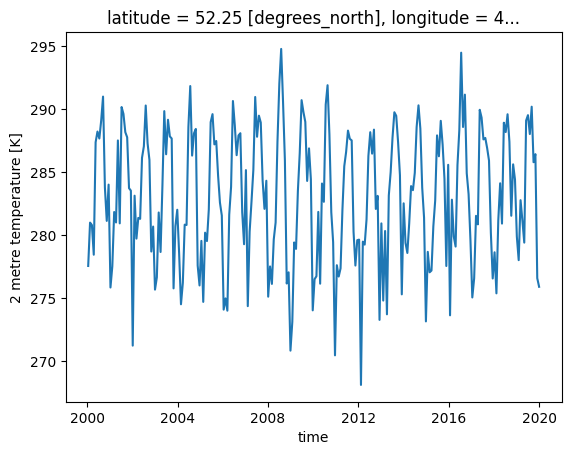

In [17]:
loc_leiden = {"latitude": 52.17, "longitude": 4.46}

# Select every 30th day of data to reduce the number of chunks that need to be downloaded
monthly_temperature = ar_full_37_1h["2m_temperature"].isel(time=slice(None, None, 24*30))
monthly_temperature = monthly_temperature.sel(time=slice("2000-01-01", "2020-01-01"))
monthly_temperature.sel(loc_leiden, method="nearest").plot()

### Prettier plots

The main showcase of the Zarr ARCO-ERA5 dataset has ended.
However, below are included some examples to show off the plotting and analysis possiblities.

#### Air temperature on an orthographic projection

We can make this plot a bit prettier by making use of [cartopy](https://scitools.org.uk/cartopy):

In [ ]:
# First we may need to install cartopy
%pip install cartopy

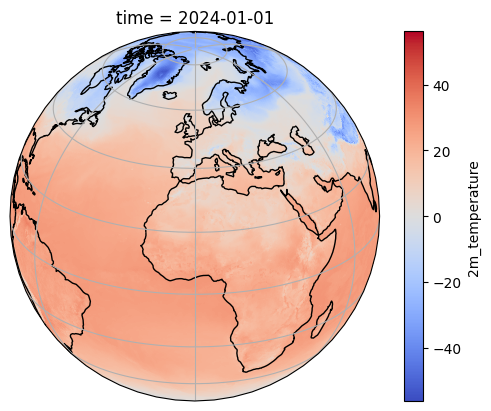

In [18]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.Orthographic(0, 25))
ax.gridlines()
ax.coastlines()

ds_t = ar_full_37_1h["2m_temperature"].sel(time="2024-01-01T00:00:00")

(ds_t - 273.15).plot(
    ax=ax, cmap="coolwarm", transform=ccrs.PlateCarree()
)

#### Air temperature and sea-ice cover

We can also add additional information to the plot such as sea-ice cover:

Text(0.5, 1.0, 'Air temperature (colors) and sea ice cover (hatched area)\n')

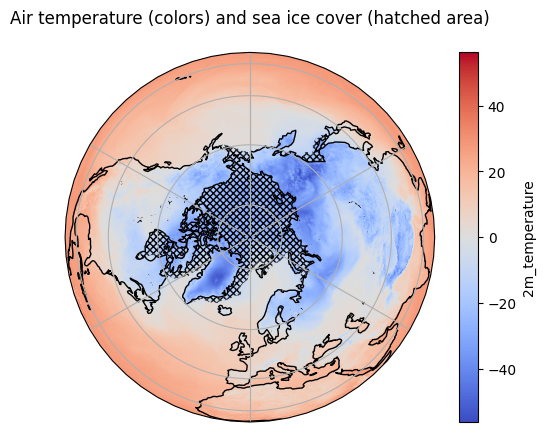

In [19]:
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.gridlines()
ax.coastlines()

ds_ice = ar_full_37_1h["sea_ice_cover"].sel(time="2024-01-01T00:00:00")

(ds_t - 273.15).plot(
    ax=ax, cmap="coolwarm", transform=ccrs.PlateCarree()
)
ds_ice.where(ds_ice>0.2).plot.contourf(
    colors=[(1, 1, 1, 0.0)],  # RGBA color (alpha is 0.0 to make it transparent)
    ax=ax, transform=ccrs.PlateCarree(), hatches=['xxxxx'], add_colorbar=False,
)
plt.title("Air temperature (colors) and sea ice cover (hatched area)\n")